In [1]:
import cv2, sys
import numpy as np

from PIL import Image
from src.model import preprocessing
from src.postprocessing import detect, array2detections, nms
# define acllite library path
sys.path.append('../../Common/acllite')
# modules of acllite library
from acllite_model import AclLiteModel
from acllite_resource import AclLiteResource

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# define device id & model path
device_id = 0
# Converted ONNX -> (MS).ckpt -> (mindspore)AIR -> CANN(5.1.RC2) -> OM
model_path= "model/51RC2blazefaceback_air.om" 

# define image & achros paths
img_path = "../../Common/data/office_people.jpg"
anchors_path = "../../Common/data/anchorsback.npy"

In [4]:
# initialize acllite library
acl_resource = AclLiteResource(device_id)
acl_resource.init()
print('[Device] NPU Device id:',acl_resource.device_id)
# load *.om model
model = AclLiteModel(model_path)

init resource stage:
Init resource success
[Device] NPU Device id: 0
Init model resource start...
[AclLiteModel] create model output dataset:
malloc output 0, size 3584
malloc output 1, size 57344
Create model output dataset success
Init model resource success


In [5]:
# read image
img_bgr = cv2.imread(img_path)

In [6]:
# 1) pre-processing stage
data = preprocessing(img_bgr,model._model_desc)

model input size 1
input  0
model input dims ({'name': 'x_1', 'dimCount': 4, 'dims': [1, 3, 256, 256]}, 0)
model input datatype 0
model output size 2
output  0
model output dims ({'name': 'output_0_trans_Cast_255_0', 'dimCount': 3, 'dims': [1, 896, 1]}, 0)
model output datatype 0
output  1
model output dims ({'name': 'output_1_trans_Cast_256_0', 'dimCount': 3, 'dims': [1, 896, 16]}, 0)
model output datatype 0
[Model] class Model init resource stage success
[PreProc] img_resized shape (3, 256, 256)
[PreProc] image_np_expanded shape (1, 3, 256, 256)


In [7]:
%timeit -n 10 -r 3
result_list = model.execute([data,]) # 2) model execution(forward) stage

In [8]:
raw_boxes = result_list[1] # get bounding box regressor predictions
raw_scores = result_list[0] # get classification confidences
print(raw_boxes.shape, raw_scores.shape)

(1, 896, 16) (1, 896, 1)


In [9]:
# 3) post-processing the raw predictions
anchors = np.load(anchors_path)
detections = array2detections(raw_boxes, raw_scores, (256, 256), anchors)

# apply non-maximum suppression to remove overlapping detections
filtered_detections = []
for i in range(len(detections)):
    faces = nms(detections[i])
    faces =np.stack(faces, axis=0) if len(faces) > 0 else np.zeros((0, 17))
    filtered_detections.append(faces)
print(filtered_detections[0], "\n")
bboxes, landmarks = detect(filtered_detections[0], img_bgr)

print("[INFO] detection done!")

[[0.28921953 0.68830603 0.44068238 0.8397689  0.7257193  0.33410507
  0.7847795  0.33641636 0.746321   0.37567058 0.74858934 0.40325308
  0.7040927  0.3379884  0.83148056 0.34309888 0.7065618 ]
 [0.21412455 0.5595926  0.3528346  0.6983027  0.59099466 0.27012256
  0.6470473  0.25717774 0.6225236  0.304072   0.63280207 0.3244483
  0.57283676 0.27561295 0.69027287 0.24415207 0.77210295]
 [0.24996233 0.40352872 0.4142666  0.56783295 0.44256616 0.30322295
  0.5083773  0.29838628 0.4722553  0.34284955 0.47779104 0.3722755
  0.41882458 0.31268227 0.5589287  0.30125377 0.84621495]
 [0.23821154 0.16572848 0.37595978 0.30347672 0.20973873 0.27787912
  0.26709315 0.27233303 0.24452278 0.30814335 0.24606976 0.3375765
  0.17344084 0.29414928 0.29624707 0.28079218 0.69739974]
 [0.23943833 0.29460096 0.36904392 0.42420653 0.33708385 0.28297204
  0.39070895 0.27473453 0.37400287 0.3119062  0.37584108 0.33638042
  0.29997322 0.2958341  0.41364315 0.27683553 0.6650567 ]] 

[INFO] detection done!


In [10]:
# draw bounding boxes and keypoints
i = 0
for bboxe in bboxes:
    cv2.rectangle(img_bgr, tuple(bboxe[2:]), tuple(bboxe[:2]), (0,0,255), 2)
    
    for landmark in landmarks[i]:
        cv2.circle(img_bgr, landmark, 3, (255,0,0), -1)
    i += 1

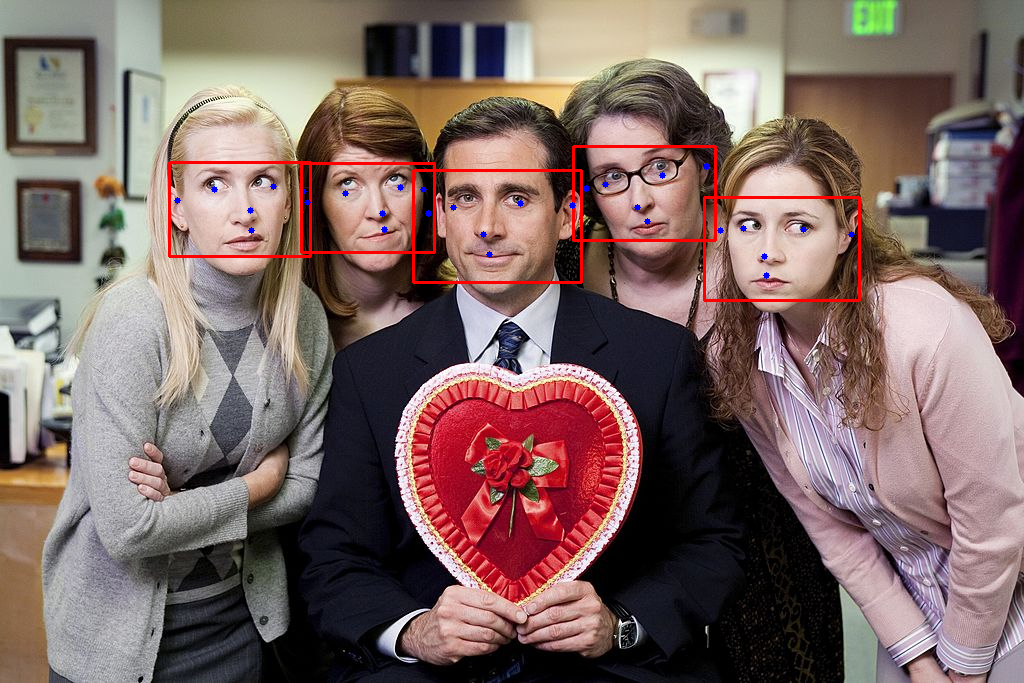

In [11]:
Image.fromarray(img_bgr[:,:,::-1])